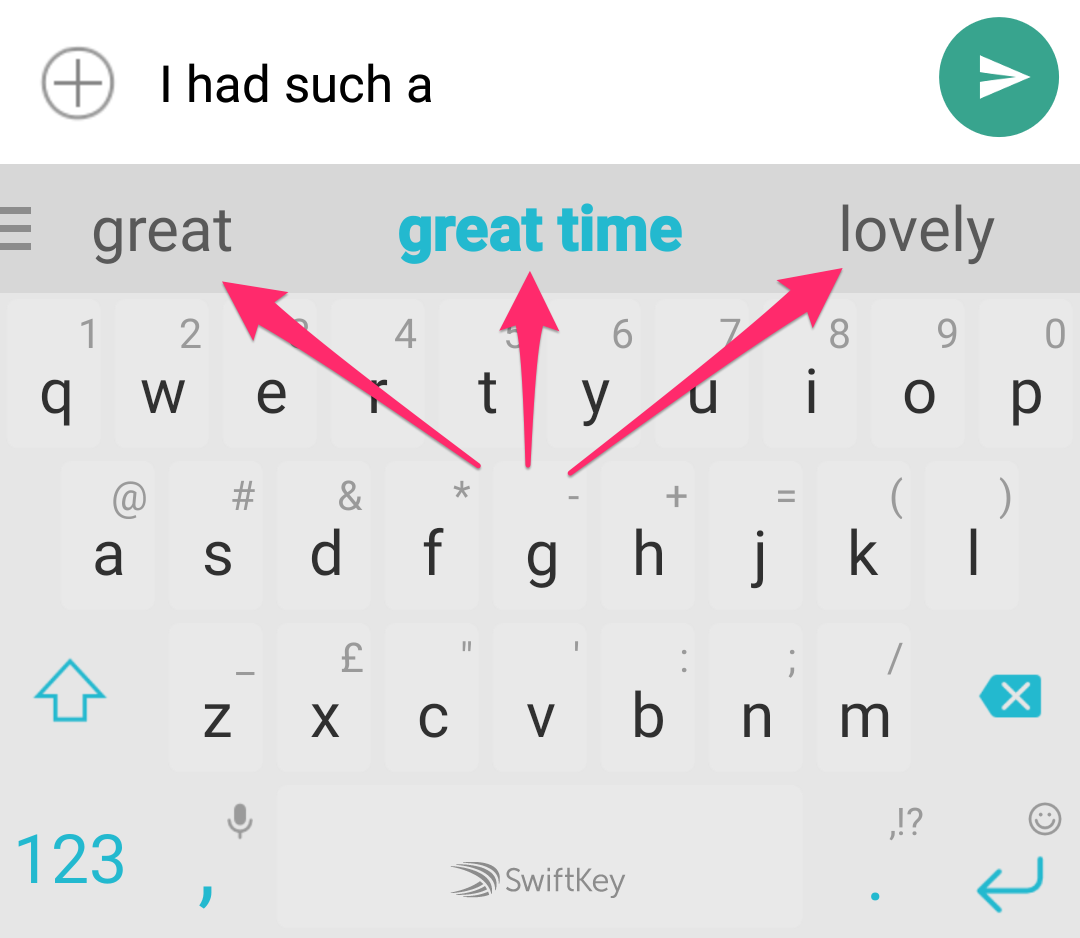

# Next Word Prediction  Model 

Most of the keyboards in smartphones give next word prediction features; google also uses next word prediction based on our browsing history. So a preloaded data is also stored in the keyboard function of our smartphones to predict the next word correctly.I will train a Deep Learning model for next word prediction using Python. I will use the Tensorflow and Keras library in Python for next word prediction model.For making a Next Word Prediction model, I will train a Recurrent Neural Network (RNN).

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

As I told earlier, Google uses our browsing history to make next word predictions, smartphones, and all the keyboards that are trained to predict the next word are trained using some data.

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

path = 'text.txt'
text = open(path, encoding='utf-8').read().lower()
print('corpus length:', len(text))

corpus length: 581888


In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Feature Engineering

Feature Engineering means taking whatever information we have about our problem and turning it into numbers that we can use to build our feature matrix. 

Here I will define a Word length which will represent the number of previous words that will determine our next word. I will define prev words to keep five previous words and their corresponding next words in the list of next words.

In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(len(sentences))

193950


Now I will create two numpy arrays x for storing the features and y for storing its corresponding label. I will iterate x and y if the word is available so that the corresponding position becomes 1.

In [5]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

# Building the Recurrent Neural Network

I will use the LSTM model, which is a very powerful RNN.

In [6]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# Training the Next Word Prediction Model 

I will be training the next word prediction model with 20 epochs

In [7]:
print("gere")
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

gere
Epoch 1/20
1440/1440 [==============================] - 148s 100ms/step - loss: 2.2798 - accuracy: 0.3481 - val_loss: 2.1222 - val_accuracy: 0.4091
Epoch 2/20
1440/1440 [==============================] - 137s 95ms/step - loss: 1.6464 - accuracy: 0.5065 - val_loss: 2.0492 - val_accuracy: 0.4407
Epoch 3/20
1440/1440 [==============================] - 137s 95ms/step - loss: 1.5213 - accuracy: 0.5407 - val_loss: 2.0113 - val_accuracy: 0.4564
Epoch 4/20
1440/1440 [==============================] - 139s 96ms/step - loss: 1.4622 - accuracy: 0.5570 - val_loss: 2.0322 - val_accuracy: 0.4570
Epoch 5/20
1440/1440 [==============================] - 141s 98ms/step - loss: 1.4248 - accuracy: 0.5687 - val_loss: 2.0273 - val_accuracy: 0.4604
Epoch 6/20
1440/1440 [==============================] - 141s 98ms/step - loss: 1.3924 - accuracy: 0.5769 - val_loss: 1.9958 - val_accuracy: 0.4708
Epoch 7/20
1440/1440 [==============================] - 133s 92ms/step - loss: 1.3735 - accuracy: 0.5800 - val_l

Now we have successfully trained our model, before moving forward to evaluating our model, it will be better to save this model for our future use.

In [8]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))


# Testing Next Word Prediction Model

Now let’s build a python program to predict the next word using our trained model

In [9]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [10]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

 ### I will create a function for next word prediction

In [11]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

This function is created to predict the next word until space is generated. It will do this by iterating the input, which will ask our RNN model and extract instances from it. Now I will modify the above function to predict multiple characters

In [12]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    print("gf")
    preds = model.predict(x, verbose=0)[0]
    print("fg")
    next_indices = sample(preds, n)
    print(text)
    print(predict_completion(text[1:]))
#     print(indices_char[16]+predict_completion(text[1:]+indices_char[16]))
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]


In [13]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

Now finally, we can use the model to predict the next word

In [14]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
gf
fg
it is not a lack of love, but a lack of 
mbswyl-byy’
hafen’ 
['the ', 'seen ', 'a ', 'many ', 'cours, ']

that which does not kill us makes us str
gf
fg
that which does not kill us makes us str
nvim’bg-blmbtbrskal-bwwbbcum 


<ipython-input-10-bf39724b6161>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)


['etched ', 'ange ', 'icken ', 'ong ', 'uck ']

i'm not upset that you lied to me, i'm u
gf
fg
i'm not upset that you lied to me, i'm u
mbiby-ramtumbub-v’-cbok-pbybyb-bis-img 
['pon ', 'nderstanced ', 'sed ', 't ', 'rders ']

and those who were seen dancing were tho
gf
fg
and those who were seen dancing were tho
-o-bbbodg-ras-abcufo-mswbbspomfrbbwtrbnm’
isarky’sabbcmttpflc-bbsumb-bbskg 
['ught ', 'se ', ' bed ', 're ', 'ne ']

it is hard enough to remember my opinion
gf
fg
it is hard enough to remember my opinion
bqum’b-ise-wbclv-wlce’ 
[', ', '.”\n\n“i ', ' and ', 's ', '\nto ']

